IMPORTING NECESSARY LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
sns.set_style("whitegrid")

C:\Users\Shreyas\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
st = '2023-01-01'
ed = '2023-12-31'
benchmarkdf = yf.download(tickers = "^NSEMDCP50", start = st, end  = ed, progress = False, period = '1d')
benchmarkdf.drop(columns = ["Open","Low","High","Volume","Adj Close"], inplace = True)
benchmarkdf

,Close
Date,
2023-01-02,8821.799805
2023-01-03,8843.349609
2023-01-04,8745.700195
2023-01-05,8808.599609
2023-01-06,8752.299805
...,...
2023-12-22,12838.200195
2023-12-26,12905.599609
2023-12-27,12946.500000


In [3]:
initial_investment = 100000
shares_bought = initial_investment / benchmarkdf['Close'][0]

benchmarkdf['Portfolio Value'] = benchmarkdf['Close']*shares_bought
benchmarkdf

,Close,Portfolio Value
Date,,
2023-01-02,8821.799805,100000.000000
2023-01-03,8843.349609,100244.279004
2023-01-04,8745.700195,99137.368666
2023-01-05,8808.599609,99850.368455
2023-01-06,8752.299805,99212.178903
...,...,...
2023-12-22,12838.200195,145528.128948
2023-12-26,12905.599609,146292.138737
2023-12-27,12946.500000,146755.767379


In [4]:
final_portfolio_value = benchmarkdf['Portfolio Value'][-1]
benchmark_returns = (final_portfolio_value - initial_investment)*100 / initial_investment
print("Benchmark Returns:", round(benchmark_returns,2),"%")

s = benchmarkdf['Portfolio Value']
s = np.log(s / s.shift(1))
s = s[1:]
sigma = (np.std(s)*math.sqrt(252))
s = s.mean()*252
print(sigma)
ra = s
print(ra)
rb = 0.07
benchmark_sr = ((ra-rb)/sigma) # Sharpe ratio
print("Benchmark Sharpe Ratio:", round(benchmark_sr,2))

Benchmark Returns: 49.01 %
0.12340268141198116
0.4118875560455703
Benchmark Sharpe Ratio: 2.77


<AxesSubplot:xlabel='Date'>

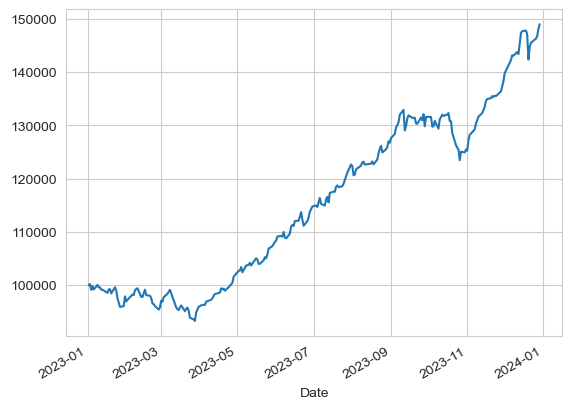

In [5]:
benchmarkdf['Portfolio Value'].plot(kind='line')

PULLING THE DATA AND FORMING A DATABASE

In [8]:

NUM_SIMULATIONS = 20000     
NUM_TRADING_DAYS = 252

stocks =["LUPIN.NS", "VOLTAS.NS", "NMDC.NS", "ZYDUSLIFE.NS", "SAIL.NS"]

from itertools import combinations
numbers = range(len(stocks))

combs = list(combinations(numbers, 3))             

for comb in combs:
  stocks_new = [stocks[i] for i in comb]
  stock_data = {}
  for stock in stocks_new:
      ticker = yf.Ticker(stock) 
      print(ticker)
      stock_data[stock] = ticker.history(start = st, end = ed)['Close']

  stock_prices = pd.DataFrame(stock_data)

  log_returns = np.log(stock_prices[1:]/stock_prices[1:].shift(1)) 

  portfolio_weights = []
  portfolio_returns = []
  portfolio_risks = []

  for i in range(NUM_SIMULATIONS):
    w = np.random.random(3)
    w = w / np.sum(w)
    portfolio_weights.append(w)
    port_return = np.sum(log_returns.mean()*w)*NUM_TRADING_DAYS
    portfolio_returns.append(port_return)
    port_risk = np.sqrt(np.dot(w.T,np.dot(log_returns.cov()*NUM_TRADING_DAYS,w)))
    portfolio_risks.append(port_risk)

  risk_free_rate = 0.07
  porfolio_weights = np.array(portfolio_weights)
  portfolio_returns = np.array(portfolio_returns)
  portfolio_risks = np.array(portfolio_risks)


  sharpe_ratios  = (portfolio_returns - risk_free_rate)/portfolio_risks 

  portfolios = pd.DataFrame({"Return": portfolio_returns,"Risk": portfolio_risks,"Sharpe": sharpe_ratios })
  ind = 0

  for i in range(len(sharpe_ratios)):
    if(sharpe_ratios[i] == np.amax(sharpe_ratios)):
      ind = i

  weights = portfolio_weights[ind]

  shares = []
  df = stock_prices.copy()
  for i in range(len(stocks_new)):
    shares_bought = (initial_investment * weights[i])/stock_prices[stocks_new[i]][0]
    shares.append(shares_bought)
  shares = np.array(shares)
  df['Portfolio Value'] = np.zeros(len(stock_prices))
  for i in range(len(stocks_new)):
    df['Portfolio Value'] += shares[i] * stock_prices[stocks_new[i]]
    
  final_portfolio_value = df['Portfolio Value'][-1]

  df_returns = (final_portfolio_value - initial_investment)*100 / initial_investment

  print("Combo Returns:", round(df_returns,2),"%")

  df_sr = sharpe_ratios[ind]
  print("Combo Sharpe Ratio:", round(df_sr,2))
  print()


yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
Combo Returns: 74.36 %
Combo Sharpe Ratio: 2.59

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
Combo Returns: 69.81 %
Combo Sharpe Ratio: 2.49

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 68.15 %
Combo Sharpe Ratio: 2.28

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
Combo Returns: 74.15 %
Combo Sharpe Ratio: 2.81

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 79.19 %
Combo Sharpe Ratio: 2.58

yfinance.Ticker object <LUPIN.NS>
yfinance.Ticker object <ZYDUSLIFE.NS>
yfinance.Ticker object <SAIL.NS>
Combo Returns: 70.6 %
Combo Sharpe Ratio: 2.51

yfinance.Ticker object <VOLTAS.NS>
yfinance.Ticker object <NMDC.NS>
yfinance.Ticker ob